In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

In [2]:
class SmartRoadDQNAgent:
    def __init__(self, state_size, action_size, num_sectors=6):
        # Configuration parameters
        self.state_size = state_size  # Number of state variables (densities + speeds)
        self.action_size = action_size  # Number of possible actions per sector
        self.num_sectors = num_sectors  # Number of road sectors

        # Learning parameters
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        # Experience replay buffer
        self.memory = deque(maxlen=10000)

        # Create main and target networks
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

        # Batch prediction containers (pre-allocate for speed)
        self.batch_states = None
        self.batch_targets = None

    def _build_model(self):
        """Build the neural network model with performance optimizations."""
        model = Sequential([
            Dense(64, input_dim=self.state_size, activation='relu'),
            Dense(64, activation='relu'),
            Dense(self.action_size * self.num_sectors, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Copy weights from main model to target model."""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Select actions for all sectors based on current state."""
        if np.random.rand() <= self.epsilon:
            # Exploration: choose random actions
            return np.random.randint(0, self.action_size, self.num_sectors)

        # Reshape once before prediction
        state_reshaped = np.reshape(state, (1, -1))

        # Exploitation: predict Q-values and choose best actions
        act_values = self.model.predict(state_reshaped, verbose=0)
        act_values = np.reshape(act_values, (self.num_sectors, self.action_size))

        # Choose best action for each sector using numpy's argmax
        return np.argmax(act_values, axis=1)

    def replay(self, batch_size):
        """Train the model using random samples from memory with batch processing."""
        if len(self.memory) < batch_size:
            return

        # Initialize batch containers if not created yet
        if self.batch_states is None:
            self.batch_states = np.zeros((batch_size, self.state_size))
            self.batch_targets = np.zeros((batch_size, self.action_size * self.num_sectors))

        # Sample a minibatch from memory
        minibatch = random.sample(self.memory, batch_size)

        # Extract states for batch prediction
        states = np.array([sample[0] for sample in minibatch])
        next_states = np.array([sample[3] for sample in minibatch])

        # Get predictions and current Q-values in batches
        targets = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        # Update targets with Bellman equation
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            if done:
                # If episode is done, reward is the final return
                for j in range(self.num_sectors):
                    targets[i, j * self.action_size + action[j]] = reward
            else:
                # Reshape for per-sector processing
                next_q = next_q_values[i].reshape(self.num_sectors, self.action_size)

                # Update Q-values with Bellman equation
                for j in range(self.num_sectors):
                    targets[i, j * self.action_size + action[j]] = reward + self.gamma * np.max(next_q[j])

        # Train on entire batch at once
        self.model.fit(states, targets, epochs=1, verbose=0, batch_size=batch_size)

        # Decay epsilon to reduce exploration over time
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [3]:
class SmartRoadEnvironment:
    """Simulated environment for a smart road with multiple sectors."""

    def __init__(self, num_sectors=6):
        self.num_sectors = num_sectors

        # Pre-allocate arrays
        self.densities = np.zeros(num_sectors)  # Traffic densities for each sector
        self.speeds = np.zeros(num_sectors)     # Speed limits for each sector
        self.new_densities = np.zeros(num_sectors)  # Pre-allocate arrays for speed

        # Action space: decrease speed, maintain speed, increase speed
        self.action_space = 3
        self.speed_changes = np.array([-10, 0, 10])  # Use numpy array for faster operations

        # Speed limits range
        self.min_speed = 60  # km/h
        self.max_speed = 120  # km/h
        self.on_ramp_max_speed = 90  # km/h for on-ramp (last sector)

        # Default speed limits
        self.default_speeds = np.array([100, 100, 100, 100, 100, 80])

        # Pre-allocate state vector
        self.state_vector = np.zeros(num_sectors * 2)

        # Initialize state
        self.reset()

    def reset(self):
        """Reset the environment to initial state."""
        # Initialize with random densities between 0.01 and 0.05
        self.densities = np.random.uniform(0.01, 0.05, self.num_sectors)

        # Initialize with default speed limits (using copy for safety)
        self.speeds = self.default_speeds.copy()

        # Return the initial state
        return self._get_state()

    def _get_state(self):
        """Combine densities and speeds to form the state vector."""
        # Faster concatenation by direct indexing rather than np.concatenate
        self.state_vector[:self.num_sectors] = self.densities
        self.state_vector[self.num_sectors:] = self.speeds / 120.0
        return self.state_vector

    def step(self, actions):
        """
        Take actions and update environment.

        Args:
            actions: array of action indices for each sector

        Returns:
            next_state: new state after actions
            reward: reward from taking actions
            done: whether the episode is complete
            info: additional information
        """
        # Apply speed changes using vectorized operations
        speed_changes = self.speed_changes[actions]
        new_speeds = self.speeds + speed_changes

        # Apply constraints - handle on-ramp separately
        mask_on_ramp = np.zeros(self.num_sectors, dtype=bool)
        mask_on_ramp[-1] = True

        # Apply different constraints to main road vs on-ramp
        max_speeds = np.where(mask_on_ramp, self.on_ramp_max_speed, self.max_speed)
        self.speeds = np.clip(new_speeds, self.min_speed, max_speeds)

        # Simulate traffic flow and update densities
        self._update_traffic_flow()

        # Calculate reward
        reward = self._calculate_reward()

        # Check if episode is done (for simplicity, never done)
        done = False

        # Return the new state, reward, done flag, and info
        next_state = self._get_state()
        info = {
            "densities": self.densities,
            "speeds": self.speeds
        }

        return next_state, reward, done, info

    def _update_traffic_flow(self):
        """Update traffic densities based on current speeds and densities."""
        # Reset new_densities array
        self.new_densities.fill(0)

        # Add random inflow to first sector (main road entrance)
        self.new_densities[0] = max(0.01, min(0.2, self.densities[0] - 0.02 + np.random.uniform(0, 0.04)))

        # Add random inflow to on-ramp
        self.new_densities[-1] = max(0.01, min(0.2, self.densities[-1] - 0.02 + np.random.uniform(0, 0.04)))

        # Vectorized speed factor calculation
        speed_factors = self.speeds / 100.0

        # Update densities for middle sectors based on inflow/outflow
        for i in range(1, self.num_sectors - 1):
            inflow = self.densities[i-1] * (1.0 - speed_factors[i] * 0.5)
            outflow = self.densities[i] * speed_factors[i] * 0.5

            # Calculate new density with some randomness
            new_density = self.densities[i] + inflow - outflow + np.random.uniform(-0.01, 0.01)
            self.new_densities[i] = max(0.01, min(0.2, new_density))

        # Special case: on-ramp affects sector 2 (merging)
        if self.num_sectors > 3:
            ramp_flow = self.densities[-1] * speed_factors[-1] * 0.3
            self.new_densities[2] += ramp_flow
            self.new_densities[2] = min(0.2, self.new_densities[2])

        # Update densities (single copy operation)
        np.copyto(self.densities, self.new_densities)

    def _calculate_reward(self):
        """Calculate reward based on traffic flow and congestion."""
        # Calculate flow (density * speed)
        flow = np.sum(self.densities * self.speeds)

        # Penalize congestion (high density)
        high_density_mask = self.densities > 0.1
        congestion_penalty = np.sum((self.densities[high_density_mask] - 0.1) * 100)

        # Penalize speed differences between adjacent sectors
        speed_diffs = np.abs(self.speeds[1:] - self.speeds[:-1])
        high_diff_mask = speed_diffs > 20
        speed_penalty = np.sum((speed_diffs[high_diff_mask] - 20) * 0.2)

        return flow - congestion_penalty - speed_penalty


In [4]:
def run_simulation(episodes=200, steps_per_episode=100):
    # Create environment and agent
    env = SmartRoadEnvironment(num_sectors=6)
    state_size = env.num_sectors * 2  # Densities and speeds for each sector
    action_size = 3  # Decrease, maintain, increase speed
    agent = SmartRoadDQNAgent(state_size, action_size, env.num_sectors)

    # Training settings
    batch_size = 32

    # Pre-allocate arrays for metrics
    all_rewards = np.zeros(episodes)
    all_densities = np.zeros(episodes)
    all_speeds = np.zeros(episodes)

    # Enable mixed precision for faster computation on compatible hardware
    if tf.config.list_physical_devices('GPU'):
        tf.keras.mixed_precision.set_global_policy('mixed_float16')

    for episode in range(episodes):
        # Reset environment
        state = env.reset()
        total_reward = 0

        # Arrays for episode metrics (pre-allocate)
        episode_densities = np.zeros(steps_per_episode)
        episode_speeds = np.zeros(steps_per_episode)

        for step in range(steps_per_episode):
            # Select action
            actions = agent.act(state)

            # Take action
            next_state, reward, done, info = env.step(actions)

            # Store experience
            agent.remember(state, actions, reward, next_state, done)

            # Update state and reward
            state = next_state
            total_reward += reward

            # Train agent (only if we have enough samples)
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

            # Track metrics
            episode_densities[step] = np.mean(info["densities"])
            episode_speeds[step] = np.mean(info["speeds"])

            if done:
                break

        # Update target model periodically (less frequent updates for speed)
        if episode % 10 == 0 and episode > 0:
            agent.update_target_model()

        # Store episode metrics
        all_rewards[episode] = total_reward
        all_densities[episode] = np.mean(episode_densities)
        all_speeds[episode] = np.mean(episode_speeds)

        # Print progress (less frequent for speed)
        if episode % 10 == 0:
            print(f"Episode: {episode}, Reward: {total_reward:.2f}, Avg Density: {all_densities[episode]:.4f}, Avg Speed: {all_speeds[episode]:.2f}")

    return agent, env, (all_rewards, all_densities, all_speeds)


In [5]:
def visualize_traffic_network(agent, env, num_steps=100, save_gif=False):
    """
    Create a network-style visualization of the traffic flow showing vehicle density
    and speed limits with dynamic color coding and arrows indicating flow direction.
    
    Args:
        agent: Trained DQN agent
        env: Smart Road environment
        num_steps: Number of steps to simulate
        save_gif: Whether to save as a GIF file
    """
    # Run a test episode
    state = env.reset()
    
    # Recording history
    density_history = np.zeros((num_steps, env.num_sectors))
    speed_history = np.zeros((num_steps, env.num_sectors))
    action_history = np.zeros((num_steps, env.num_sectors))
    
    for step in range(num_steps):
        # Select action with no exploration
        epsilon_backup = agent.epsilon
        agent.epsilon = 0  # Turn off exploration
        actions = agent.act(state)
        agent.epsilon = epsilon_backup
        
        # Take action
        next_state, reward, done, info = env.step(actions)
        
        # Record state
        density_history[step] = info["densities"]
        speed_history[step] = info["speeds"]
        action_history[step] = actions
        
        # Update state
        state = next_state
    
    # Create figure for animation
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Road parameters
    road_width = 1.0
    road_length = 10.0
    sector_length = road_length / env.num_sectors
    
    def draw_road_network(frame):
        ax.clear()
        
        # Draw main road
        for i in range(env.num_sectors):
            # Skip the last sector (on-ramp) in main road
            if i == env.num_sectors - 1:
                continue
                
            # Calculate position
            x_start = i * sector_length
            x_end = (i + 1) * sector_length
            
            # Get density and speed for coloring
            density = density_history[frame, i]
            speed = speed_history[frame, i]
            
            # Normalize for color mapping
            density_norm = min(1.0, density * 5)  # Scale for better visualization
            
            # Colors based on density (red = congested, green = free flow)
            road_color = (density_norm, 1.0 - density_norm, 0.2)
            
            # Draw road segment
            road_rect = patches.Rectangle(
                (x_start, 0), 
                sector_length, 
                road_width, 
                linewidth=1, 
                edgecolor='black', 
                facecolor=road_color, 
                alpha=0.8
            )
            ax.add_patch(road_rect)
            
            # Add traffic flow arrows
            flow_scale = min(1.0, speed / 120.0) * 0.8  # Scale arrow by speed
            arrow_length = sector_length * flow_scale
            
            # Add more arrows for higher speed
            num_arrows = 1 + int(speed / 40)  # 1 arrow at min speed, more at higher speeds
            for j in range(num_arrows):
                pos = x_start + (j + 1) * sector_length / (num_arrows + 1)
                ax.arrow(
                    pos, road_width/2, 
                    arrow_length, 0, 
                    head_width=0.2, 
                    head_length=0.1, 
                    fc='white', 
                    ec='white', 
                    alpha=0.7
                )
            
            # Add text for speed limit
            ax.text(
                x_start + sector_length/2, 
                road_width/2, 
                f"{int(speed)}", 
                ha='center', 
                va='center', 
                fontsize=9, 
                fontweight='bold', 
                color='white'
            )
        
        # Draw on-ramp (last sector)
        ramp_index = env.num_sectors - 1
        ramp_density = density_history[frame, ramp_index]
        ramp_speed = speed_history[frame, ramp_index]
        ramp_density_norm = min(1.0, ramp_density * 5)
        ramp_color = (ramp_density_norm, 1.0 - ramp_density_norm, 0.2)
        
        # Position on-ramp to merge at sector 2
        ramp_x_end = 2 * sector_length
        ramp_x_start = ramp_x_end - sector_length * 1.5
        ramp_y_start = -2  # Below main road
        
        # Draw on-ramp road
        ramp_points = [
            (ramp_x_start, ramp_y_start),
            (ramp_x_end - 0.2, ramp_y_start),
            (ramp_x_end, 0)  # Merge point
        ]
        
        ax.add_patch(
            patches.Polygon(
                ramp_points + [(ramp_x_end, ramp_y_start+0.5), (ramp_x_start, ramp_y_start+0.5)],
                closed=True,
                linewidth=1,
                edgecolor='black',
                facecolor=ramp_color,
                alpha=0.8
            )
        )
        
        # Add flow arrow for on-ramp
        ramp_flow_scale = min(1.0, ramp_speed / 120.0) * 0.6
        ramp_mid_x = (ramp_x_start + ramp_x_end) / 2
        ramp_mid_y = (ramp_y_start + 0) / 2
        
        # Calculate arrow direction tangent to the ramp
        arrow_dx = (ramp_x_end - ramp_x_start) * ramp_flow_scale
        arrow_dy = (0 - ramp_y_start) * ramp_flow_scale
        
        ax.arrow(
            ramp_mid_x, ramp_mid_y,
            arrow_dx * 0.5, arrow_dy * 0.5,
            head_width=0.2,
            head_length=0.15,
            fc='white',
            ec='white',
            alpha=0.7
        )
        
        # Add text for on-ramp speed
        ax.text(
            ramp_mid_x - 0.2, 
            ramp_mid_y - 0.2, 
            f"{int(ramp_speed)}", 
            ha='center', 
            va='center', 
            fontsize=9, 
            fontweight='bold', 
            color='white'
        )
        
        # Add controller actions indicators
        for i in range(env.num_sectors):
            if i == env.num_sectors - 1:  # on-ramp
                x_pos = ramp_mid_x
                y_pos = ramp_mid_y - 0.7
            else:
                x_pos = i * sector_length + sector_length/2
                y_pos = road_width + 0.5
            
            action = action_history[frame, i]
            action_text = "▼" if action == 0 else "◆" if action == 1 else "▲"
            action_color = "red" if action == 0 else "yellow" if action == 1 else "green"
            
            ax.text(
                x_pos, y_pos, 
                action_text, 
                ha='center', 
                va='center', 
                fontsize=14, 
                color=action_color,
                fontweight='bold'
            )
        
        # Add density indicators as "car" symbols
        for i in range(env.num_sectors):
            density = density_history[frame, i]
            num_cars = int(density * 100)  # Scale for visualization
            
            if i == env.num_sectors - 1:  # on-ramp
                x_range = np.linspace(ramp_x_start, ramp_x_end - 0.3, num_cars)
                y_offset = ramp_y_start + 0.25
                
                for x in x_range:
                    # Calculate y based on ramp slope (simple linear interpolation)
                    progress = (x - ramp_x_start) / (ramp_x_end - ramp_x_start)
                    y = ramp_y_start + progress * (0 - ramp_y_start)
                    ax.plot(x, y, 'ko', markersize=3)
            else:
                x_range = np.linspace(i * sector_length + 0.1, (i+1) * sector_length - 0.1, num_cars)
                for x in x_range:
                    ax.plot(x, road_width/2, 'ko', markersize=3)
        
        # Add frame information
        ax.text(
            0.02, 0.95, 
            f"Step: {frame}", 
            transform=ax.transAxes,
            fontsize=12,
            fontweight='bold'
        )
        
        # Add legend for speed/density
        density_patches = [
            patches.Rectangle((0, 0), 1, 1, facecolor=(0.0, 1.0, 0.2), alpha=0.8),
            patches.Rectangle((0, 0), 1, 1, facecolor=(0.5, 0.5, 0.2), alpha=0.8),
            patches.Rectangle((0, 0), 1, 1, facecolor=(1.0, 0.0, 0.2), alpha=0.8)
        ]
        ax.legend(
            density_patches, 
            ['Low Density', 'Medium Density', 'High Density'],
            loc='upper right',
            framealpha=0.7
        )
        
        # Add action legend
        action_labels = [
            '▼ = Decrease Speed',
            '◆ = Maintain Speed', 
            '▲ = Increase Speed'
        ]
        ax.text(
            0.02, 0.02, 
            '\n'.join(action_labels), 
            transform=ax.transAxes,
            fontsize=9,
            bbox=dict(facecolor='white', alpha=0.7)
        )
        
        # Set plot limits and labels
        ax.set_xlim(-0.5, road_length + 0.5)
        ax.set_ylim(ramp_y_start - 1, road_width + 1.5)
        ax.set_title("Smart Road Traffic Simulation", fontsize=14)
        ax.set_xlabel("Road Position")
        ax.set_aspect('equal')
        ax.grid(alpha=0.3)
        
    # Create animation
    ani = FuncAnimation(
        fig, 
        draw_road_network, 
        frames=num_steps,
        interval=200, 
        repeat=True
    )
    
    if save_gif:
        ani.save('traffic_network_animation.gif', writer='pillow', fps=5)
    
    plt.tight_layout()
    plt.show()
    
    return ani

In [6]:
def visualize_speed_limits_evolution(episodes=200, steps_per_episode=100):
    """
    Run simulation and visualize how speed limits in each sector evolve over episodes
    as the agent learns.
    
    Args:
        episodes: Number of episodes to run
        steps_per_episode: Number of steps per episode
    """
    
    # Create environment and agent
    env = SmartRoadEnvironment(num_sectors=6)
    state_size = env.num_sectors * 2  # Densities and speeds for each sector
    action_size = 3  # Decrease, maintain, increase speed
    agent = SmartRoadDQNAgent(state_size, action_size, env.num_sectors)
    
    # Training settings
    batch_size = 32
    
    # Storage for episode-end speed limits
    speed_history = np.zeros((episodes, env.num_sectors))
    
    # Storage for action frequency
    action_counts = np.zeros((episodes, env.num_sectors, action_size))
    
    # Run simulation
    for episode in range(episodes):
        # Reset environment
        state = env.reset()
        
        # Initialize episode variables
        episode_speeds = np.zeros((steps_per_episode, env.num_sectors))
        episode_actions = np.zeros((steps_per_episode, env.num_sectors))
        
        for step in range(steps_per_episode):
            # Select action
            actions = agent.act(state)
            
            # Track actions
            for i in range(env.num_sectors):
                action_counts[episode, i, actions[i]] += 1
                
            # Take action
            next_state, reward, done, info = env.step(actions)
            
            # Store experience
            agent.remember(state, actions, reward, next_state, done)
            
            # Update state
            state = next_state
            
            # Track speeds at each step
            episode_speeds[step] = info["speeds"]
            episode_actions[step] = actions
            
            # Train agent
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
                
            if done:
                break
        
        # Update target model periodically
        if episode % 10 == 0 and episode > 0:
            agent.update_target_model()
        
        # Store final speeds of this episode
        speed_history[episode] = episode_speeds[-1]
        
        # Print progress
        if episode % 10 == 0:
            print(f"Episode: {episode}, Avg Speed: {np.mean(episode_speeds[-1]):.2f}")
    
    # Create visualization
    fig = plt.figure(figsize=(15, 12))
    
    # 1. Line plot of speed limit for each sector over episodes
    ax1 = plt.subplot(3, 1, 1)
    for i in range(env.num_sectors):
        sector_name = f"Sector {i}" if i < env.num_sectors - 1 else "On-ramp"
        ax1.plot(range(episodes), speed_history[:, i], label=sector_name)
    
    ax1.set_title('Speed Limit Evolution by Sector', fontsize=14)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Speed Limit (km/h)')
    ax1.set_ylim(60, 120)
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)
    
    # 2. Heatmap of speed limits over episodes
    ax2 = plt.subplot(3, 1, 2)
    
    # Create a custom colormap from blue (slow) to green (medium) to red (fast)
    colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue -> Green -> Red
    cmap_name = 'speed_cmap'
    speed_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)
    
    im = ax2.imshow(
        speed_history.T,
        aspect='auto',
        cmap=speed_cmap,
        vmin=60, vmax=120,
        extent=[0, episodes, env.num_sectors-0.5, -0.5]
    )
    
    ax2.set_title('Speed Limits Heatmap Over Episodes', fontsize=14)
    ax2.set_ylabel('Road Sector')
    ax2.set_yticks(range(env.num_sectors))
    ax2.set_yticklabels([f"Sector {i}" if i < env.num_sectors - 1 else "On-ramp" for i in range(env.num_sectors)])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('Speed Limit (km/h)')
    
    # 3. Action distribution over episodes for each sector
    ax3 = plt.subplot(3, 1, 3)
    
    # Calculate percentages of each action over episodes (with smoothing)
    window_size = 5
    action_percentages = np.zeros((episodes, env.num_sectors, action_size))
    
    for i in range(episodes):
        # Apply moving average for smoothing
        start_idx = max(0, i - window_size // 2)
        end_idx = min(episodes, i + window_size // 2 + 1)
        window = action_counts[start_idx:end_idx]
        
        # Calculate percentages
        window_sum = np.sum(window, axis=2, keepdims=True)
        window_sum[window_sum == 0] = 1  # Avoid division by zero
        action_percentages[i] = np.sum(window, axis=0) / window_sum[0]
    
    # Stacked area chart for first sector
    sectors_to_show = [0, 2, env.num_sectors - 1]  # First sector, merging sector, on-ramp
    
    for idx, sector in enumerate(sectors_to_show):
        ax = plt.subplot(3, 3, 7 + idx)
        sector_name = f"Sector {sector}" if sector < env.num_sectors - 1 else "On-ramp"
        
        ax.stackplot(
            range(episodes),
            action_percentages[:, sector, 0],  # Decrease
            action_percentages[:, sector, 1],  # Maintain
            action_percentages[:, sector, 2],  # Increase
            labels=['Decrease', 'Maintain', 'Increase'],
            alpha=0.7,
            colors=['#FF6B6B', '#FFD166', '#06D6A0']
        )
        
        ax.set_title(f'Action Distribution - {sector_name}', fontsize=12)
        ax.set_xlabel('Episode')
        ax.set_ylabel('Action Percentage')
        ax.set_ylim(0, 1)
        
        if idx == 2:  # Only add legend to the last plot
            ax.legend(loc='upper right', fontsize=8)
        
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('speed_limits_evolution.png', dpi=300)
    plt.show()
    
    return agent, env, speed_history

In [7]:
def visualize_metrics(metrics):
    """
    Visualize training metrics from the simulation.
    
    Args:
        metrics: Tuple of (rewards, densities, speeds) from simulation
    """
    rewards, densities, speeds = metrics
    episodes = range(len(rewards))
    
    plt.figure(figsize=(15, 12))
    
    # Plot rewards
    plt.subplot(3, 1, 1)
    plt.plot(episodes, rewards, 'b-')
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    # Plot average densities
    plt.subplot(3, 1, 2)
    plt.plot(episodes, densities, 'r-')
    plt.title('Average Traffic Density per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Density')
    plt.ylim([0, 0.2])
    
    # Plot average speeds
    plt.subplot(3, 1, 3)
    plt.plot(episodes, speeds, 'g-')
    plt.title('Average Speed per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Speed (km/h)')
    plt.ylim([60, 120])
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

def visualize_traffic_flow(agent, env, num_steps=100):
    """
    Run a test episode and visualize traffic flow.
    
    Args:
        agent: Trained DQN agent
        env: Smart Road environment
        num_steps: Number of steps to simulate
    """
    # Run a test episode
    state = env.reset()
    
    # Recording history
    density_history = np.zeros((num_steps, env.num_sectors))
    speed_history = np.zeros((num_steps, env.num_sectors))
    action_history = np.zeros((num_steps, env.num_sectors))
    
    for step in range(num_steps):
        # Select action with no exploration
        epsilon_backup = agent.epsilon
        agent.epsilon = 0  # Turn off exploration
        actions = agent.act(state)
        agent.epsilon = epsilon_backup
        
        # Take action
        next_state, reward, done, info = env.step(actions)
        
        # Record state
        density_history[step] = info["densities"]
        speed_history[step] = info["speeds"]
        action_history[step] = actions
        
        # Update state
        state = next_state
    
    # Create visualization
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Density heatmap
    im1 = axes[0].imshow(
        density_history.T, 
        aspect='auto',
        cmap='plasma',
        vmin=0, vmax=0.2,
        extent=[0, num_steps, env.num_sectors-0.5, -0.5]
    )
    axes[0].set_title('Traffic Density Over Time')
    axes[0].set_ylabel('Road Sector')
    axes[0].set_yticks(range(env.num_sectors))
    plt.colorbar(im1, ax=axes[0], label='Density')
    
    # Speed heatmap
    im2 = axes[1].imshow(
        speed_history.T, 
        aspect='auto',
        cmap='viridis',
        vmin=60, vmax=120, 
        extent=[0, num_steps, env.num_sectors-0.5, -0.5]
    )
    axes[1].set_title('Speed Limits Over Time')
    axes[1].set_ylabel('Road Sector')
    axes[1].set_yticks(range(env.num_sectors))
    plt.colorbar(im2, ax=axes[1], label='Speed (km/h)')
    
    # Action heatmap
    action_labels = {0: 'Decrease', 1: 'Maintain', 2: 'Increase'}
    im3 = axes[2].imshow(
        action_history.T, 
        aspect='auto',
        cmap='coolwarm',
        vmin=-0.5, vmax=2.5,
        extent=[0, num_steps, env.num_sectors-0.5, -0.5]
    )
    axes[2].set_title('Controller Actions Over Time')
    axes[2].set_xlabel('Simulation Step')
    axes[2].set_ylabel('Road Sector')
    axes[2].set_yticks(range(env.num_sectors))
    plt.colorbar(im3, ax=axes[2], label='Action', ticks=[0, 1, 2], 
                orientation='vertical')
    
    plt.tight_layout()
    plt.savefig('traffic_flow.png')
    plt.show()

def create_traffic_animation(agent, env, num_steps=100, save_gif=False):
    """
    Create an animation of traffic flow.
    
    Args:
        agent: Trained DQN agent
        env: Smart Road environment
        num_steps: Number of steps to simulate
        save_gif: Whether to save as a GIF file
    """
    # Run a test episode
    state = env.reset()
    
    # Recording history
    density_history = np.zeros((num_steps, env.num_sectors))
    speed_history = np.zeros((num_steps, env.num_sectors))
    
    for step in range(num_steps):
        # Select action with no exploration
        epsilon_backup = agent.epsilon
        agent.epsilon = 0  # Turn off exploration
        actions = agent.act(state)
        agent.epsilon = epsilon_backup
        
        # Take action
        next_state, reward, done, info = env.step(actions)
        
        # Record state
        density_history[step] = info["densities"]
        speed_history[step] = info["speeds"]
        
        # Update state
        state = next_state
    
    # Create animation
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Initialize plots
    road_len = 100  # Arbitrary road length for visualization
    road_segments = np.linspace(0, road_len, env.num_sectors+1)
    segment_centers = (road_segments[:-1] + road_segments[1:]) / 2
    
    density_bars = ax1.bar(segment_centers, density_history[0], 
                          width=(road_len/env.num_sectors)*0.8,
                          color='blue', alpha=0.7)
    ax1.set_ylim(0, 0.2)
    ax1.set_title('Traffic Density by Sector')
    ax1.set_ylabel('Density')
    
    speed_bars = ax2.bar(segment_centers, speed_history[0], 
                        width=(road_len/env.num_sectors)*0.8,
                        color='green', alpha=0.7)
    ax2.set_ylim(60, 120)
    ax2.set_title('Speed Limits by Sector')
    ax2.set_ylabel('Speed (km/h)')
    ax2.set_xlabel('Road Position (km)')
    
    def update(frame):
        # Update the data for each bar
        for i, bar in enumerate(density_bars):
            bar.set_height(density_history[frame][i])
        
        for i, bar in enumerate(speed_bars):
            bar.set_height(speed_history[frame][i])
        
        ax1.set_title(f'Traffic Density by Sector - Step {frame}')
        return density_bars + speed_bars
    
    # Create animation
    ani = FuncAnimation(fig, update, frames=range(num_steps),
                        interval=200, blit=True)
    
    if save_gif:
        ani.save('traffic_animation.gif', writer='pillow', fps=5)
    
    plt.tight_layout()
    plt.show()
    
    return ani


In [8]:
if __name__ == "__main__":
    # Configure TensorFlow to use memory growth to avoid allocating all GPU memory
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    # Run the simulation
    agent, env, metrics = run_simulation()
    print("Simulation complete!")


c:\users\no1sh\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 0, Reward: 3938.64, Avg Density: 0.1370, Avg Speed: 94.13
Episode: 10, Reward: 3786.84, Avg Density: 0.1394, Avg Speed: 93.37
Episode: 20, Reward: 3770.54, Avg Density: 0.1192, Avg Speed: 95.08
Episode: 30, Reward: 2123.90, Avg Density: 0.0618, Avg Speed: 95.07
Episode: 40, Reward: 2831.14, Avg Density: 0.0892, Avg Speed: 92.63
Episode: 50, Reward: 3309.13, Avg Density: 0.1008, Avg Speed: 95.08
Episode: 60, Reward: 2657.21, Avg Density: 0.0727, Avg Speed: 96.65
Episode: 70, Reward: 2593.95, Avg Density: 0.0975, Avg Speed: 95.08
Episode: 80, Reward: 3446.29, Avg Density: 0.1225, Avg Speed: 95.08
Episode: 90, Reward: 2664.29, Avg Density: 0.0818, Avg Speed: 95.08
Episode: 100, Reward: 3841.63, Avg Density: 0.1269, Avg Speed: 96.97
Episode: 110, Reward: 2889.59, Avg Density: 0.0674, Avg Speed: 91.82
Episode: 120, Reward: 3571.18, Avg Density: 0.1115, Avg Speed: 96.27
Episode: 130, Reward: 3678.65, Avg Density: 0.1455, Avg Speed: 95.08
Episode: 140, Reward: 3535.73, Avg Density: 0

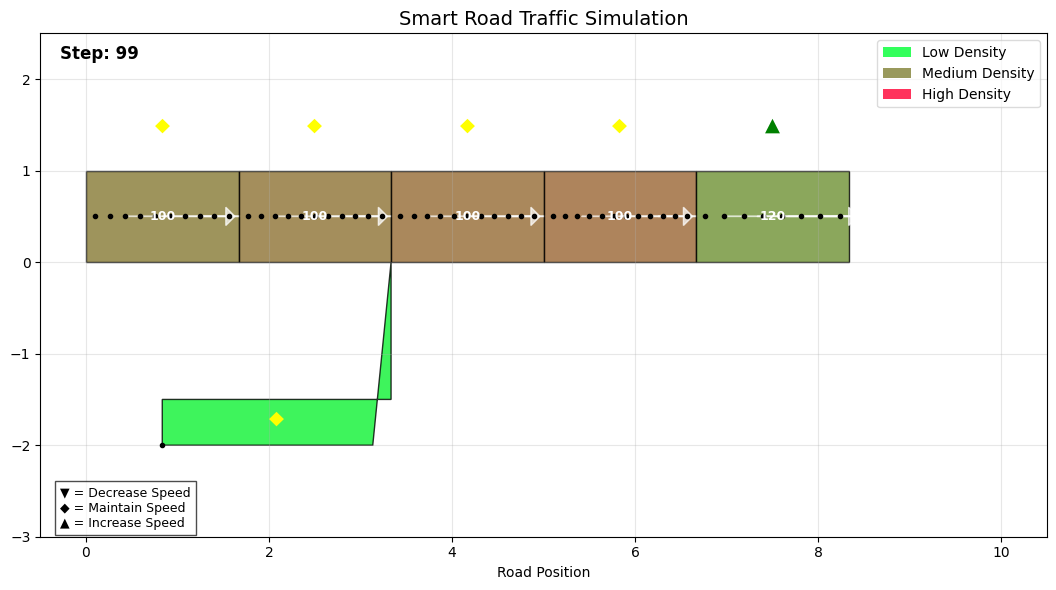

In [9]:
    # Traffic network visualization
    animation = visualize_traffic_network(agent, env, num_steps=100, save_gif=True)

c:\users\no1sh\appdata\local\programs\python\python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 0, Avg Speed: 95.00
Episode: 10, Avg Speed: 103.33
Episode: 20, Avg Speed: 103.33
Episode: 30, Avg Speed: 105.00
Episode: 40, Avg Speed: 103.33
Episode: 50, Avg Speed: 101.67
Episode: 60, Avg Speed: 106.67
Episode: 70, Avg Speed: 111.67
Episode: 80, Avg Speed: 105.00
Episode: 90, Avg Speed: 108.33
Episode: 100, Avg Speed: 105.00
Episode: 110, Avg Speed: 101.67
Episode: 120, Avg Speed: 103.33
Episode: 130, Avg Speed: 105.00
Episode: 140, Avg Speed: 105.00
Episode: 150, Avg Speed: 105.00
Episode: 160, Avg Speed: 108.33
Episode: 170, Avg Speed: 111.67
Episode: 180, Avg Speed: 111.67
Episode: 190, Avg Speed: 108.33


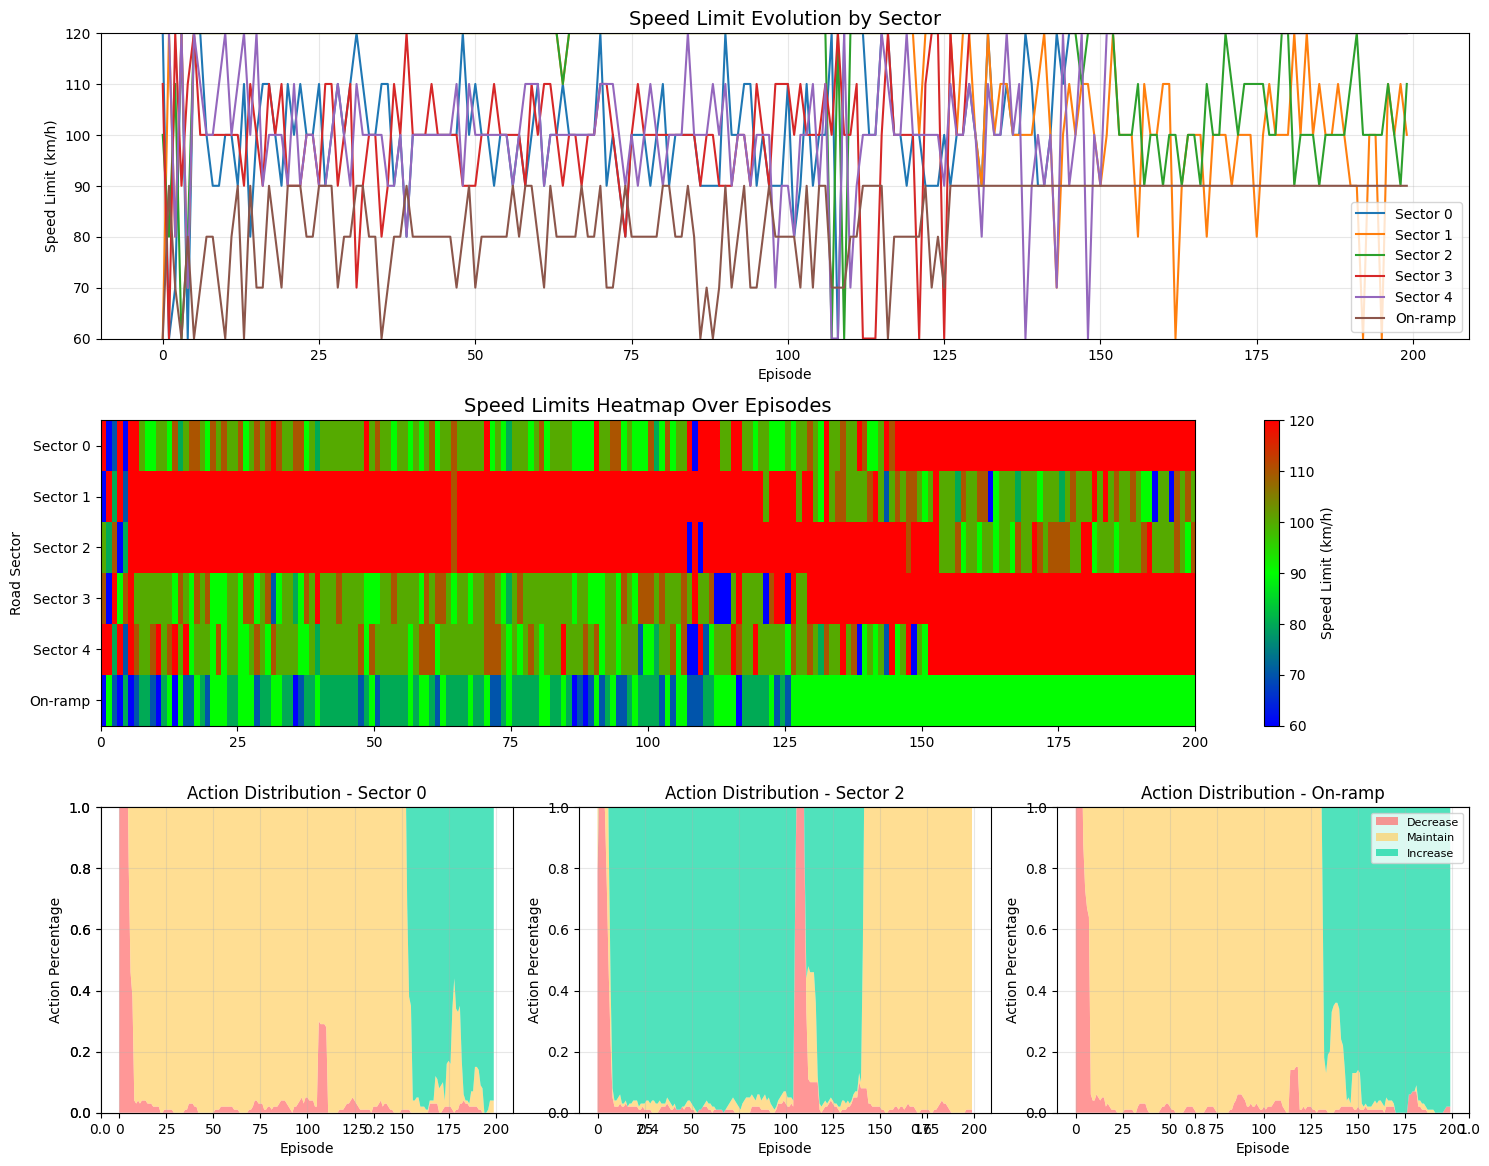

In [10]:
    # Visualize speed limits evolution
    agent, env, speed_history = visualize_speed_limits_evolution(episodes=200, steps_per_episode=100)

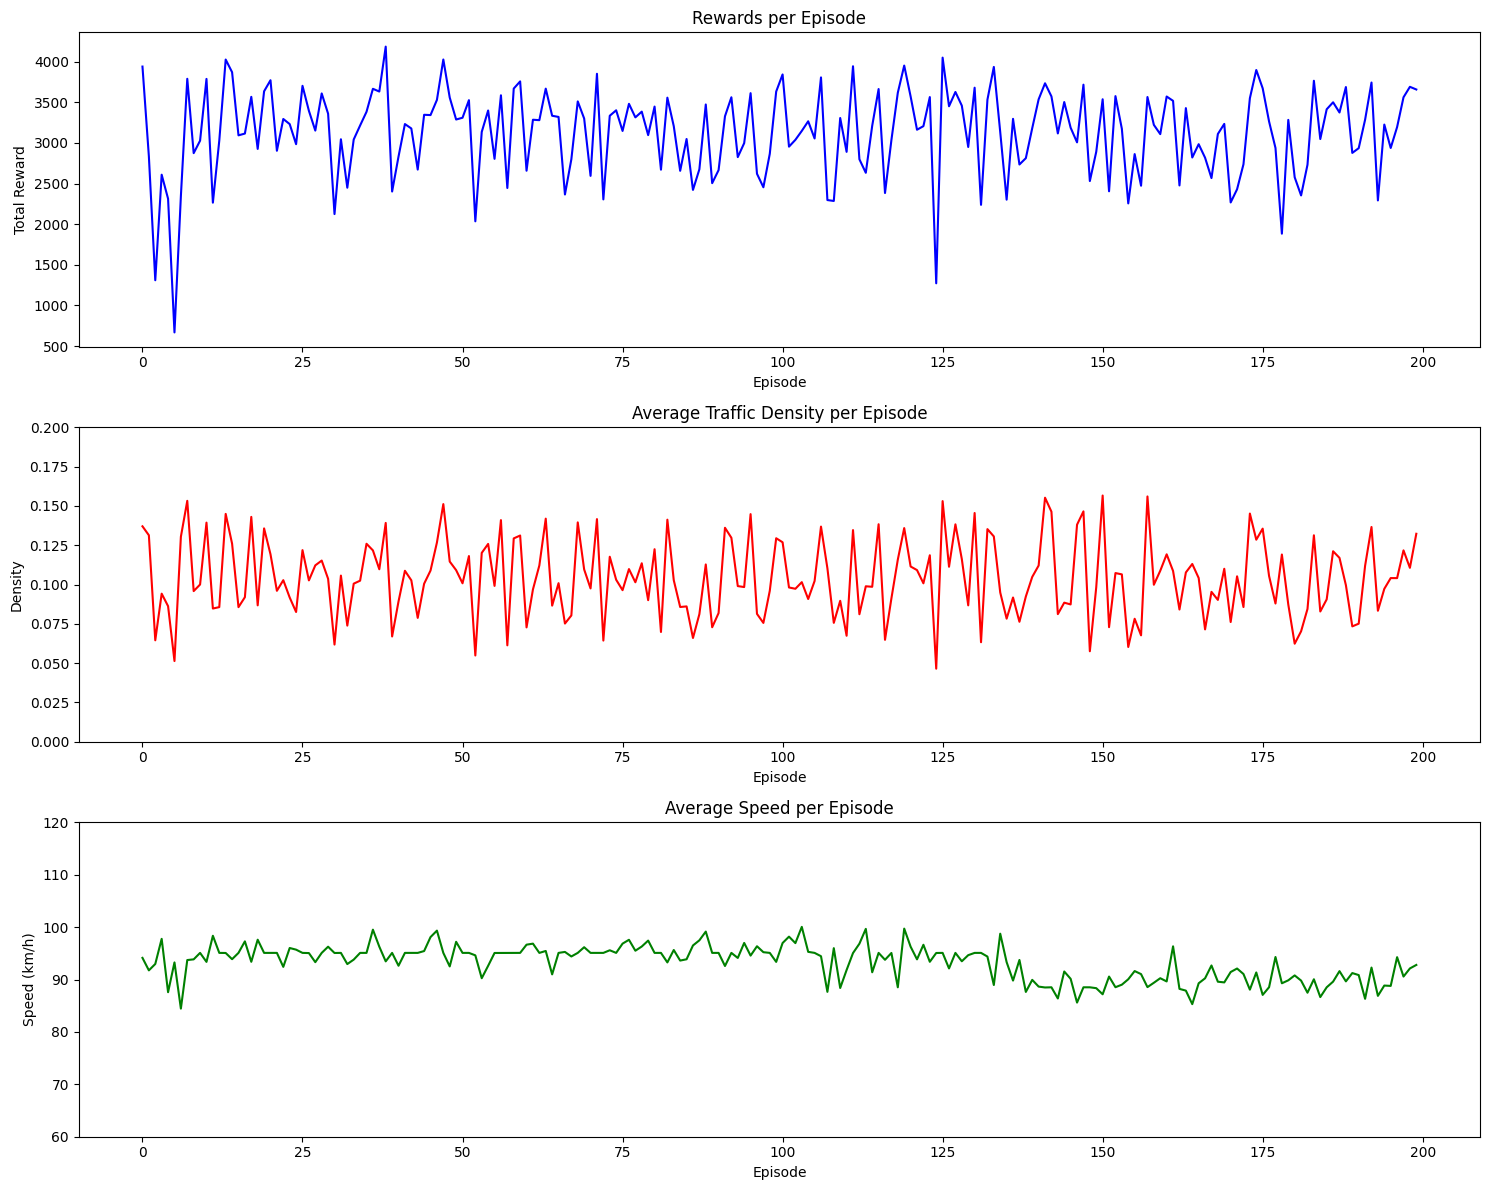

In [11]:
    # Visualize training metrics
    visualize_metrics(metrics)

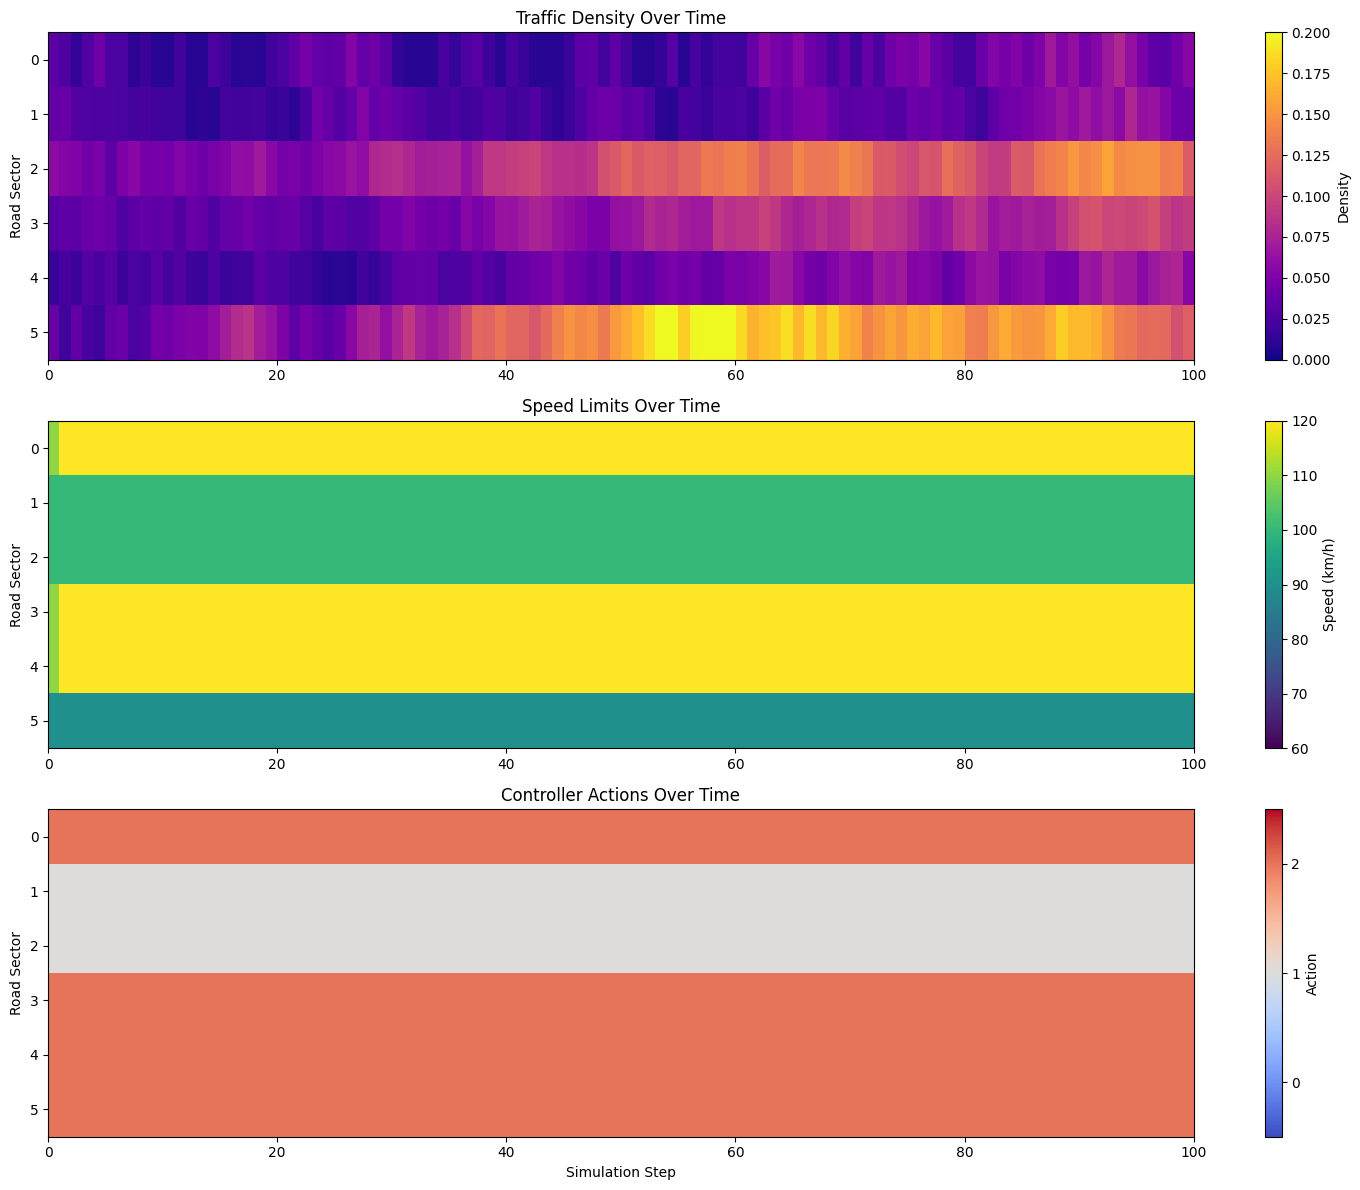

In [12]:
    # Visualize traffic flow patterns
    visualize_traffic_flow(agent, env)

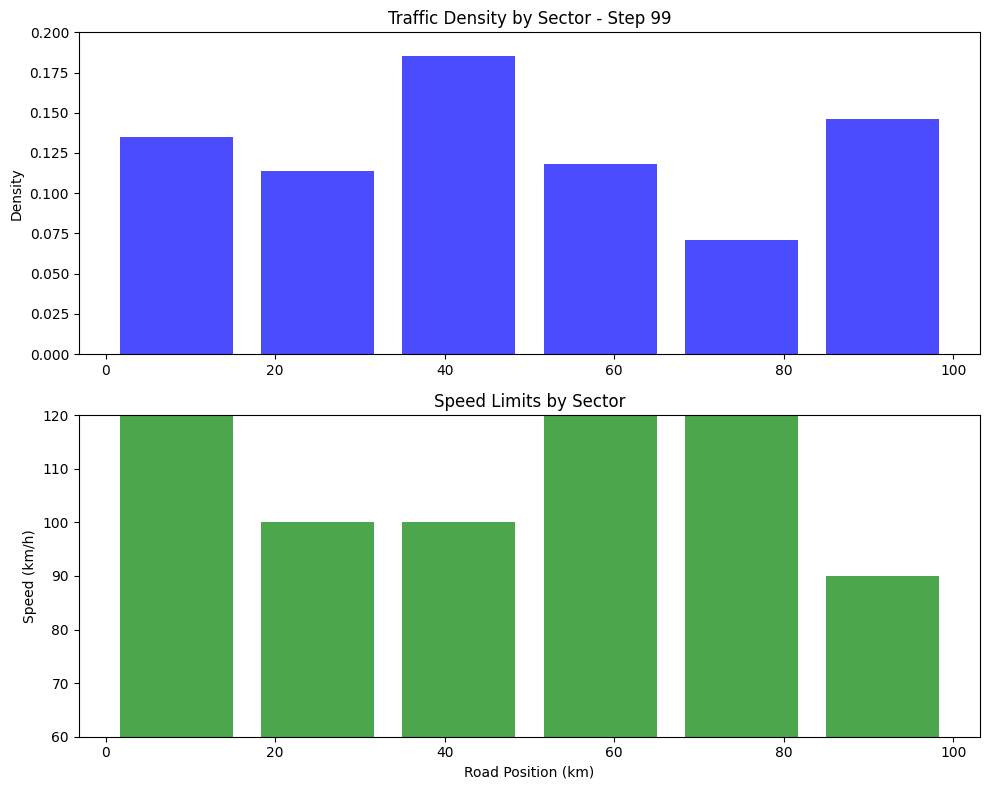

In [13]:
    # Create animated visualization
    animation2 = create_traffic_animation(agent, env, save_gif=True)